# Classificação de fácies sísmicas usando aprendizado de maquina

O conjunto de dados que usaremos vem de um exercício de classe da Universidade de Kansas nos campos de gás Hugoton e Panoma. Para maior informação do origem dos dados ver Dubois et al. (2007).

O código esta baseado no repositorio da [SEG](https://github.com/seg/tutorials-2016/tree/master/1610_Facies_classification).

Dubois, M. K., G. C. Bohling, and S. Chakrabarti, 2007, Comparison of four approaches to a rock facies classification problem: Computers & Geosciences, 33, no. 5, 599–617, https://doi.org/10.1016/j.cageo.2006.08.011

## 1. Montar o Drive

Executando as seguintes linhas de codigo, podemos montar nosso Google Drive no Colab:

```python
from google.colab import drive
drive.mount('/content/drive')
```
Depois, um link sera apresentado onde temos que accesar para obter um token. Finalmente temos que colar o token nosso Colab para permitir o acceso ao nossos arquivos.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/My\ Drive/Colabs/Classificacao_Facies

/content/drive/My Drive/Colabs/Classificacao_Facies


## 2. Carregando os dados

In [3]:
# Carregando as bibliotecas necessarias
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
# Leitura do conjunto de dados
dataset_filename = 'facies_vectors.csv'
training_data = pd.read_csv(dataset_filename) # carregar o arquivo csv
# Conversão das colunas "Well Name" e "Formation" para o tipo categorical
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


## 3. Análise de dados

### 3.1. Explorando os dados

Temos 10 poços com os seguintes nomes:

In [5]:
training_data['Well Name'].unique()

['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (10, object): ['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', ..., 'NOLAN',
                          'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']

Os 7 atributos disponíveis no conjunto de dados são os seguintes:
* [Gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR)
* [Resistivity](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10)
* [Photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE)
* [Neutron-density porosity difference](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI)
* Average neutron-density porosity (PHIND)
* Nonmarine/marine indicator (NM_M)
* Relative position (RELPOS)

A tabela a seguir lista as fácies, seus labels abreviados e suas fàcies adjacentes.

Fácies | Descrição | Label| Fácies adjacentes
:---: | :---: | :---: | :--:
1 | Nonmarine sandstone | SS | 2
2 | Nonmarine coarse siltstone | CSiS | 1,3
3 | Nonmarine fine siltstone | FSiS| 2
4 | Marine siltstone and shale | SiSh| 5
5 | Mudstone (limestone) | MS | 4,6
6 | Wackestone (limestone) | WS | 5,7
7 | Dolomite | D | 6,8
8 | Packstone-grainstone (limestone) | PS | 6,7,9
9 | Phylloid-algal bafflestone (limestone) | BS | 7,8

Vamos definir um mapa de cores para representar as fácies

In [6]:
facies_color_map = {'SS': '#F4D03F',
                    'CSiS': '#F5B041',
                    'FSiS': '#DC7633',
                    'SiSh': '#6E2C00',
                    'MS': '#1B4F72',
                    'WS': '#2E86C1',
                    'D': '#AED6F1',
                    'PS': '#A569BD',
                    'BS': '#196F3D'}

facies_labels = list(facies_color_map.keys())

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,FSiS
...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,MS
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,MS
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,MS
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,MS


Visão rápida da distribuição estatística dos atributos. Olhando para os valores `count`, a maioria dos valores tem 4149 valores válidos, exceto para` PE`, que tem 3232. Vamos a remover os dados que não tem um valor `PE` válido.

In [7]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [8]:
PE_mask = training_data['PE'].notnull().values
training_data = training_data[PE_mask]
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


### 3.2. Visualização dos Poços

Função para visualizar o poço e seus atributos

In [9]:
def make_facies_log_plot(logs, facies_colors):
    # Ordenar los valores por profundidade
    logs = logs.sort_values(by='Depth')
    # Mapa de cores
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    # Dicionário com atributos e cor para cada atributo
    feat_dict = {"GR":"green",
                 "ILD_log10":"blue",
                 "DeltaPHI":"magenta",
                 "PHIND":"red",
                 "PE":"black"}
    n_feats = len(feat_dict)
    # Profundidade mínima e máxima
    ztop=logs.Depth.min()
    zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(10, 12))    
    for i, key in enumerate(feat_dict):
        ax[i].plot(logs[key], logs.Depth, '-', color=feat_dict[key])
    im=ax[n_feats].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1))
    cbar.set_ticklabels('')

    for i, key in enumerate(feat_dict):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)        
        ax[i].set_xlabel(key)
        ax[i].set_xlim(logs[key].min(),logs[key].max())
        if i>0:
            ax[i].set_yticklabels([])

    ax[n_feats].set_xlabel('Fácies')    
    ax[n_feats].set_yticklabels([])
    ax[n_feats].set_xticklabels([])
    
    f.suptitle('Poço: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

Placing the log plotting code in a function will make it easy to plot the logs from multiples wells, and can be reused later to view the results when we apply the facies classification model to other wells.  The function was written to take a list of colors and facies labels as parameters.  

We then show log plots for wells `SHRIMPLIN` and `SHANKLE`.  

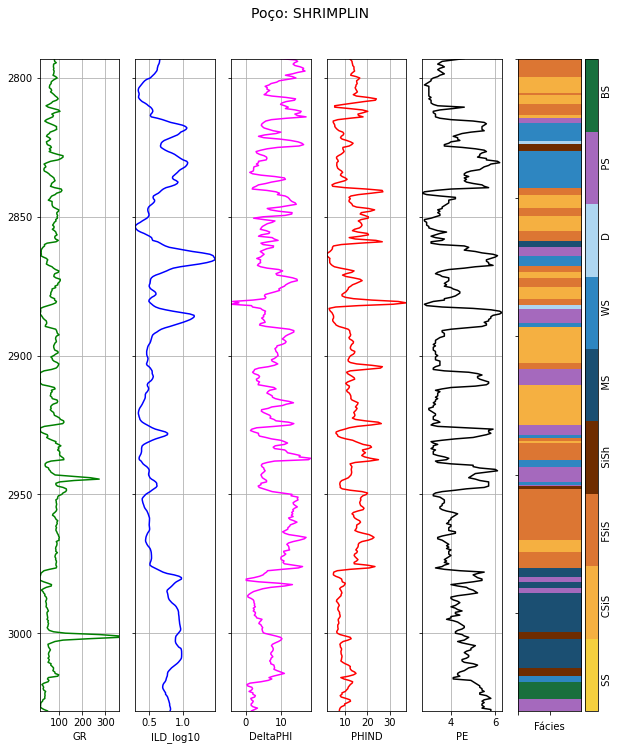

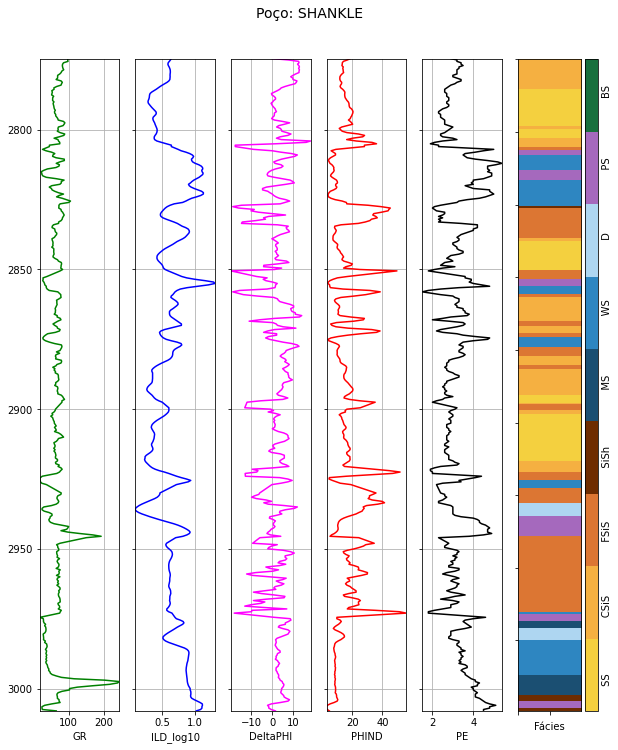

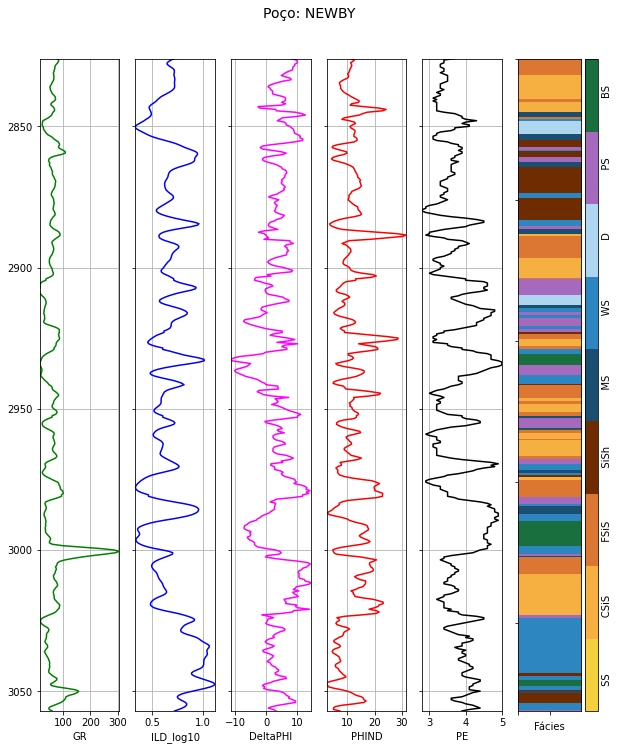

In [10]:
facies_colors = list(facies_color_map.values())

well_log = training_data[training_data['Well Name'] == 'SHRIMPLIN']
make_facies_log_plot(well_log, facies_colors)

well_log = training_data[training_data['Well Name'] == 'SHANKLE']
make_facies_log_plot(well_log, facies_colors)

well_log = training_data[training_data['Well Name'] == 'NEWBY']
make_facies_log_plot(well_log, facies_colors)

### 3.3. Distribuição dos dados

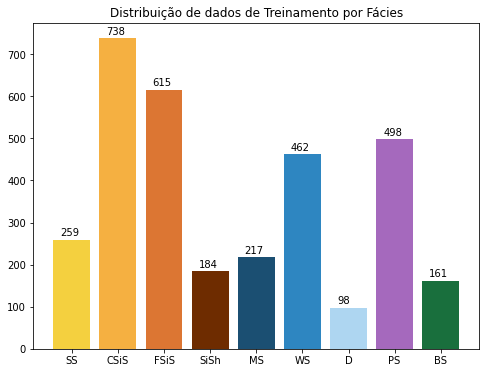

In [11]:
# Numero de amostras por classe
_, facies_counts = np.unique(training_data['Facies'].values, return_counts=True)
facies_colors = list(facies_color_map.values())

plt.figure(figsize=(8,6))
plt.bar(facies_labels, facies_counts, color=facies_colors)
plt.title("Distribuição de dados de Treinamento por Fácies")
xlocs,_ = plt.xticks()
for i, v in enumerate(facies_counts):
    plt.text(xlocs[i] - 0.25, v + 10, str(v))
plt.show()

### 3.4. Analise dos Atributos

Pairplot dos atributos

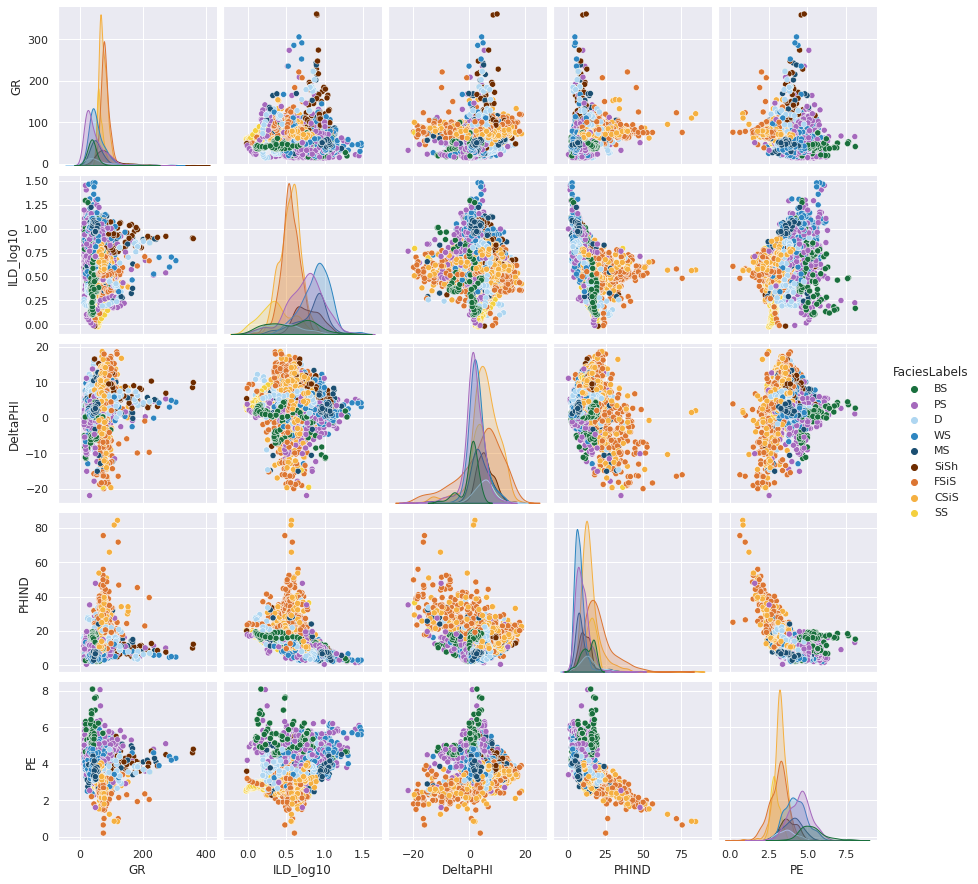

In [59]:
import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))
sns.reset_orig()

## 4. Support Vector Machine - SVM

### 4.1. Conjunto de dados

In [13]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


**Normalização**

Os atributos estão em diferentes faixas de valores, devido a isso, é necessario normalizar os atributos.
Vamos usar a normalização padrão:

$$z = {(x - \mu) \over \sigma}$$

onde:

$\mu$ é a média, e $\sigma$ é o desvio padrão

In [14]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)
pd.DataFrame(scaled_features).describe()

,0,1,2,3,4,5,6
count,3.232000e+03,3.232000e+03,3.232000e+03,3.232000e+03,3.232000e+03,3.232000e+03,3.232000e+03
mean,2.941816e-16,4.854478e-16,-4.356560e-17,-9.195752e-17,6.832406e-16,1.556511e-15,5.989090e-17
std,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00
min,-1.714285e+00,-2.765296e+00,-4.856726e+00,-1.680121e+00,-3.934108e+00,-9.969107e-01,-1.779569e+00
25%,-6.229169e-01,-6.202015e-01,-4.582685e-01,-6.672647e-01,-6.975496e-01,-9.969107e-01,-8.623869e-01
50%,-1.342848e-02,-7.560721e-02,-1.140783e-02,-1.731943e-01,-1.936510e-01,-9.969107e-01,1.992191e-02
75%,4.372920e-01,7.031033e-01,5.494992e-01,3.858948e-01,6.417158e-01,1.003099e+00,8.612539e-01
max,9.562844e+00,3.462598e+00,2.876809e+00,9.212618e+00,4.876027e+00,1.003099e+00,1.672943e+00


Divisão do conjunto de dados em conjunto de treinamento e teste:

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.2, random_state=42)

print("Conjunto de dados: \t\tX: {}, \t\tY:{}".format(scaled_features.shape, correct_facies_labels.shape))
print("Conjunto de Treinamento: \tX_train: {}, \tY_train:{}".format(X_train.shape, y_train.shape))
print("Conjunto de Teste: \t\tX_test: {}, \tY_test:{}".format(X_test.shape, y_test.shape))

Conjunto de dados: 		X: (3232, 7), 		Y:(3232,)
Conjunto de Treinamento: 	X_train: (2585, 7), 	Y_train:(2585,)
Conjunto de Teste: 		X_test: (647, 7), 	Y_test:(647,)


### 4.2. Treinamento do classificador SVM

In [29]:
from sklearn import svm
# Classificador SVM
clf_SVM = svm.SVC()
# Treinamento
clf_SVM.fit(X_train,y_train)
# Predição nos conjunto de teste
predicted_labels_SVM = clf_SVM.predict(X_test)

Avaliação da predição

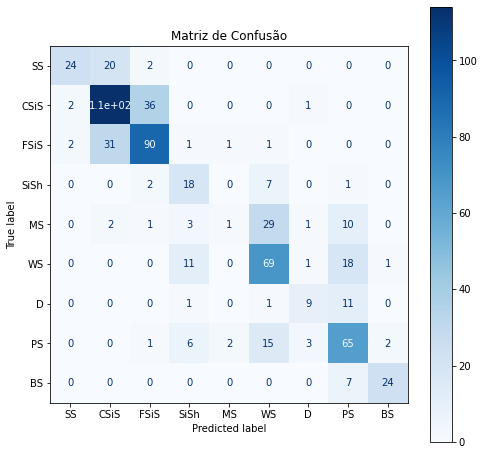

In [31]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

conf_SVM = confusion_matrix(y_test, predicted_labels_SVM)
fig, ax = plt.subplots(figsize=(8, 8))
disp  = plot_confusion_matrix(clf_SVM, X_test, y_test, 
                              display_labels=facies_labels, 
                              cmap=plt.cm.Blues, 
                              ax=ax)
disp.ax_.set_title("Matriz de Confusão")
print(disp)

Métricas de avaliação

In [21]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

`adjacent_facies[i]` é um array com as fácies adjacentes.

In [32]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]], dtype="object")
print('Facies classification accuracy = {}'.format(accuracy(conf_SVM)))
print('Adjacent facies classification accuracy = {}'.format(accuracy_adjacent(conf_SVM, adjacent_facies)))

Facies classification accuracy = 0.6398763523956723
Adjacent facies classification accuracy = 0.9165378670788253


### 4.3. Busca dos melhores parâmetros

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1,1, 10], 
              'gamma': [10,1,0.1],
              'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=2, n_jobs=-1)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 406.2min finished


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [10, 1, 0.1],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

In [ ]:
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
cv_conf = confusion_matrix(y_test, grid_predictions)

print('Optimized facies classification accuracy = {}'.format(accuracy(cv_conf)))
print('Optimized adjacent facies classification accuracy = {}'.format(accuracy_adjacent(cv_conf, adjacent_facies)))

SVC(C=10, gamma=1)
Optimized facies classification accuracy = 0.77
Optimized adjacent facies classification accuracy = 0.94


### 4.4. Usando o modelo com novos dados

In [23]:
well_data = pd.read_csv('validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911
...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556


Normalização padrão

In [24]:
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)
X_unknown = scaler.transform(well_features)

Predição

In [33]:
y_unknown = clf_SVM.predict(X_unknown)
well_data['Facies'] = y_unknown
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,2
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,2
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,2
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,2
...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,2
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,2
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,2
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,2


In [34]:
# Nomes do poços
well_data['Well Name'].unique()

['STUART', 'CRAWFORD']
Categories (2, object): ['STUART', 'CRAWFORD']

Visualização dos resultados

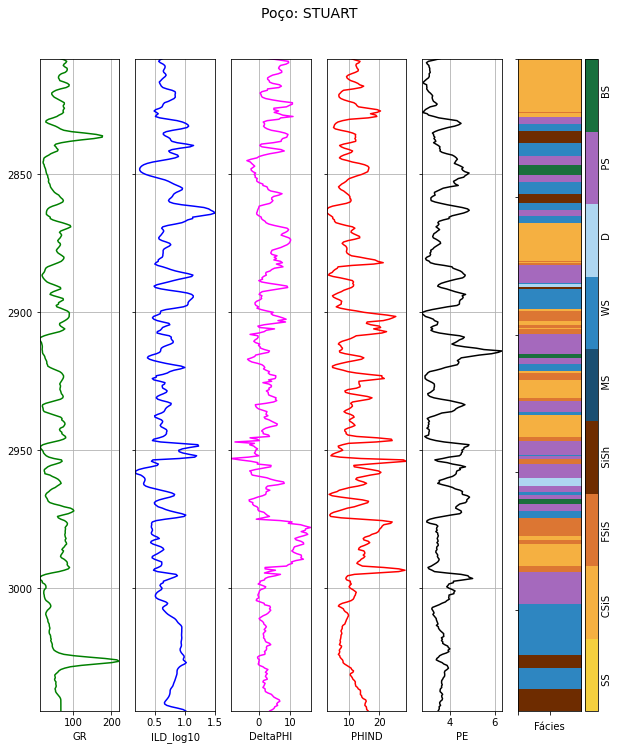

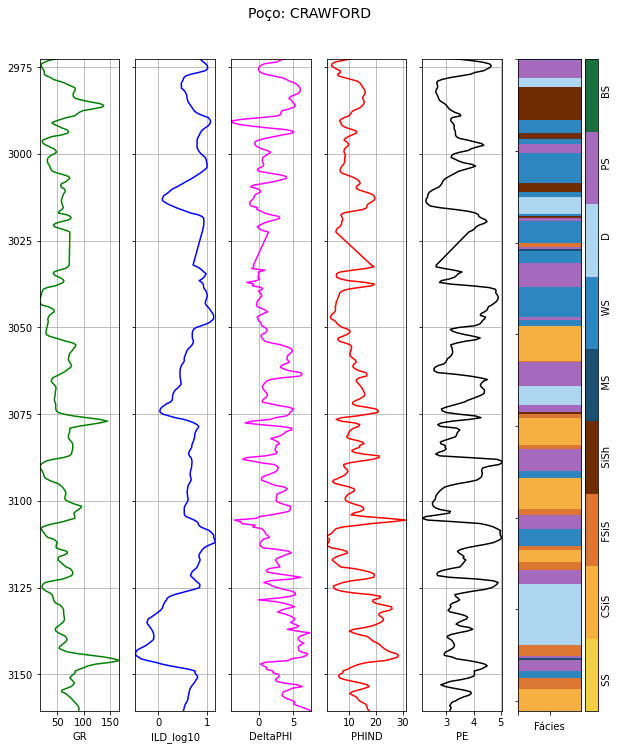

In [35]:
well_log = well_data[well_data['Well Name'] == 'STUART']
make_facies_log_plot(well_log, facies_colors)

well_log = well_data[well_data['Well Name'] == 'CRAWFORD']
make_facies_log_plot(well_log, facies_colors)

## 5. Random Forest - RF

### 5.1. Treinamento do classificador RF

In [40]:
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(n_estimators=200)
clf_RF.fit(X_train,y_train)
predicted_labels_RF = clf_RF.predict(X_test)

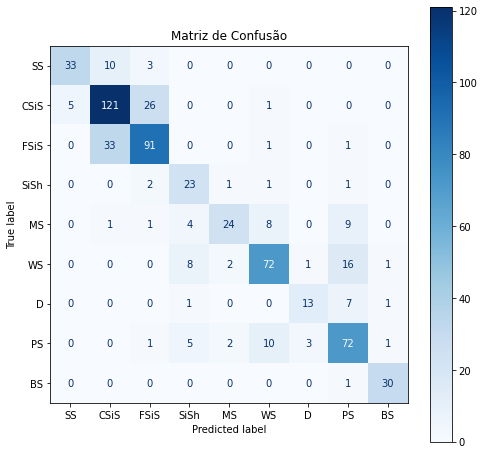

In [60]:
conf_RF = confusion_matrix(y_test, predicted_labels_RF)
fig, ax = plt.subplots(figsize=(8, 8))
disp  = plot_confusion_matrix(clf_RF, X_test, y_test, 
                              display_labels=facies_labels, 
                              cmap=plt.cm.Blues, values_format="d",
                              ax=ax)
disp.ax_.set_title("Matriz de Confusão")
print(disp)

In [42]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]], dtype="object")

print("SVM")
print('Facies classification accuracy = {}'.format(accuracy(conf_SVM)))
print('Adjacent facies classification accuracy = {}'.format(accuracy_adjacent(conf_SVM, adjacent_facies)))

print("\nRF")
print('Facies classification accuracy = {}'.format(accuracy(conf_RF)))
print('Adjacent facies classification accuracy = {}'.format(accuracy_adjacent(conf_RF, adjacent_facies)))

SVM
Facies classification accuracy = 0.6398763523956723
Adjacent facies classification accuracy = 0.9165378670788253

RF
Facies classification accuracy = 0.740340030911901
Adjacent facies classification accuracy = 0.9381761978361669


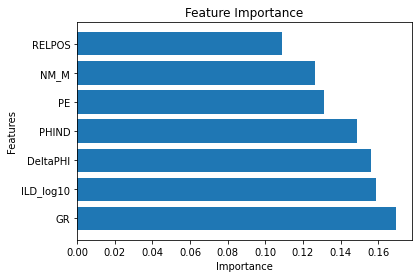

In [61]:
features_names = ["GR","ILD_log10","DeltaPHI","PHIND","PE","NM_M","RELPOS"]
feature_importance = pd.Series(clf_RF.feature_importances_, index=features_names).sort_values(ascending=False)

plt.barh(features_names, feature_importance)
plt.title("Feature Importance")
plt.ylabel("Features")
plt.xlabel("Importance")
plt.show()

### 5.1. Busca dos melhores parâmetros

In [47]:
from sklearn.model_selection import RandomizedSearchCV

# Numero de arvores (estimadores)
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Numero de atributos a considerar em cada arvore
max_features = ['auto', 'sqrt']
# Maxima profundidade dos arvores
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Numero minimo de amostras para dividir um nó
min_samples_split = [2, 5, 10]
# Numero minimo de amostras em cada folha do arvore
min_samples_leaf = [1, 2, 4]
# Metodo para seleção de amostras para treinamento de cada arvore
bootstrap = [True, False]
# Random Grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [49]:
# Usando um random grid para a busca dos parâmetros
rf = RandomForestClassifier()
# Parâmetros do Random Search: # iterations, # folds
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1)
# Treinamento
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [53]:
predicted_labels_RF_best = rf_random.best_estimator_.predict(X_test)
conf_RF_best = confusion_matrix(y_test, predicted_labels_RF_best)

adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]], dtype="object")

print("SVM")
print('Facies classification accuracy = {}'.format(accuracy(conf_SVM)))
print('Adjacent facies classification accuracy = {}'.format(accuracy_adjacent(conf_SVM, adjacent_facies)))

print("\nRF")
print('Facies classification accuracy = {}'.format(accuracy(conf_RF)))
print('Adjacent facies classification accuracy = {}'.format(accuracy_adjacent(conf_RF, adjacent_facies)))

print("\nRF Best")
print('Facies classification accuracy = {}'.format(accuracy(conf_RF_best)))
print('Adjacent facies classification accuracy = {}'.format(accuracy_adjacent(conf_RF_best, adjacent_facies)))

SVM
Facies classification accuracy = 0.6398763523956723
Adjacent facies classification accuracy = 0.9165378670788253

RF
Facies classification accuracy = 0.740340030911901
Adjacent facies classification accuracy = 0.9381761978361669

RF Best
Facies classification accuracy = 0.7573415765069552
Adjacent facies classification accuracy = 0.9412673879443586
